# Milestone 2

## 1. Setup EC2 instance

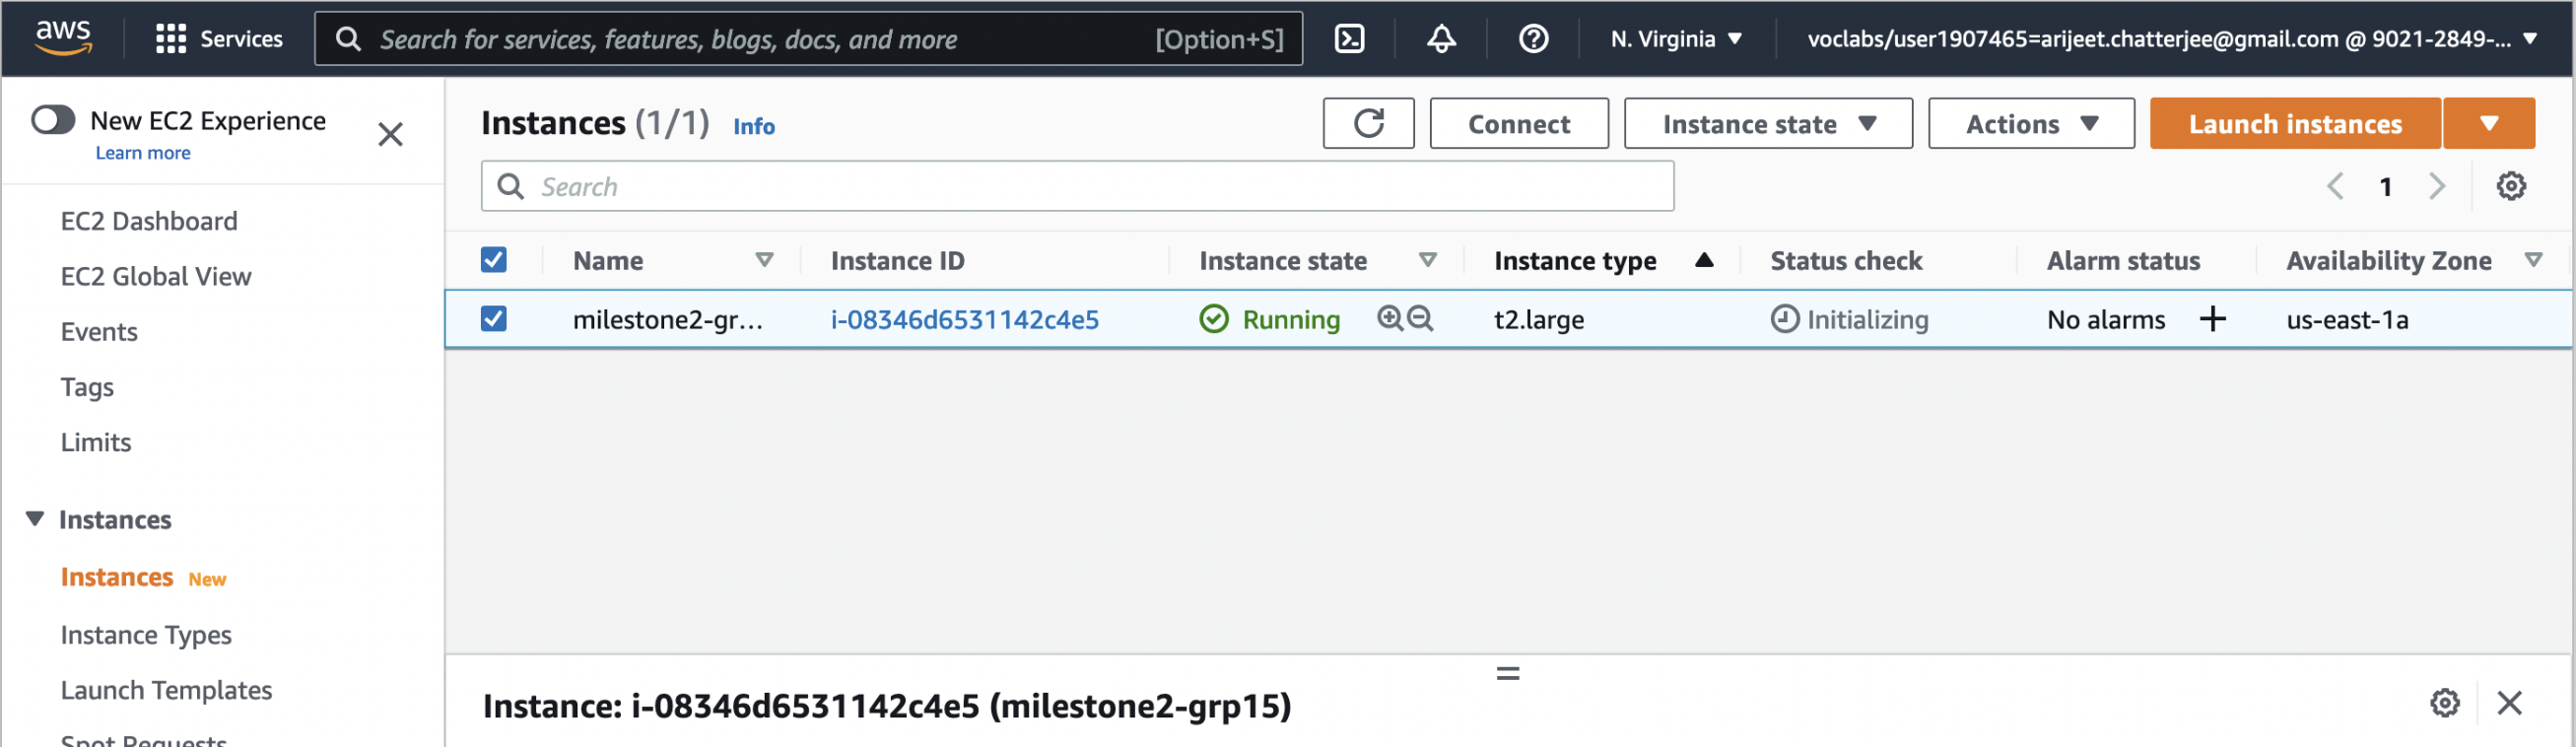

## 2. Setup JupyterHub

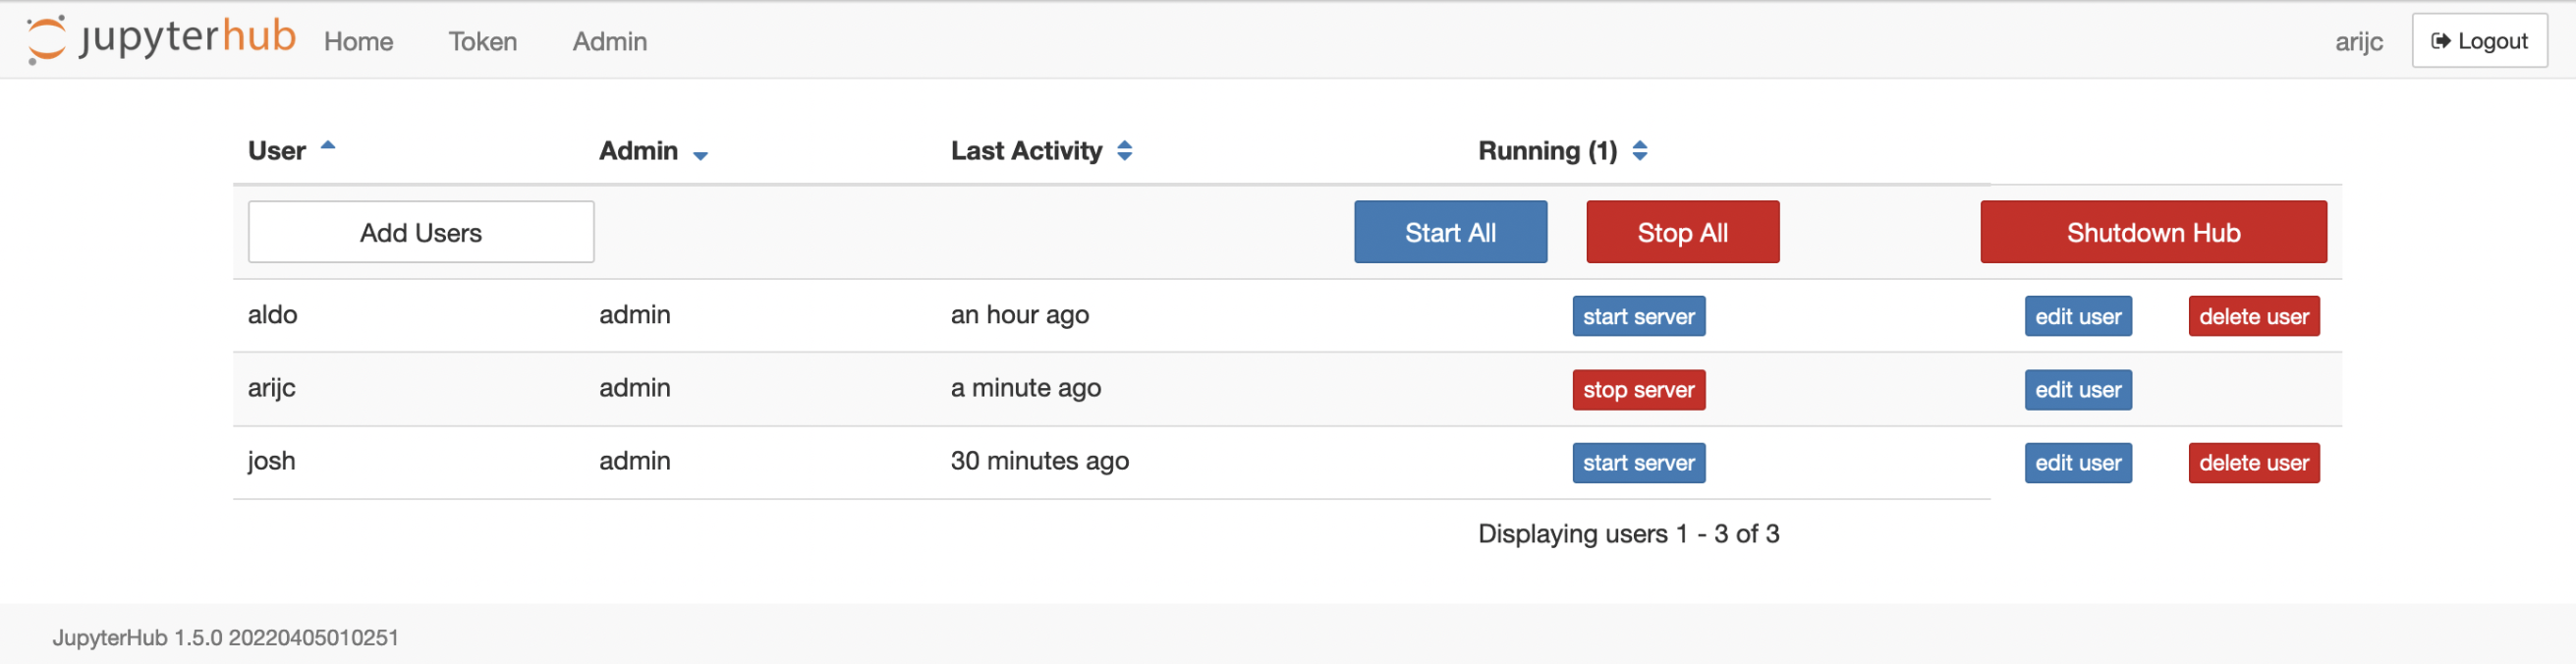

## 3. Setup server

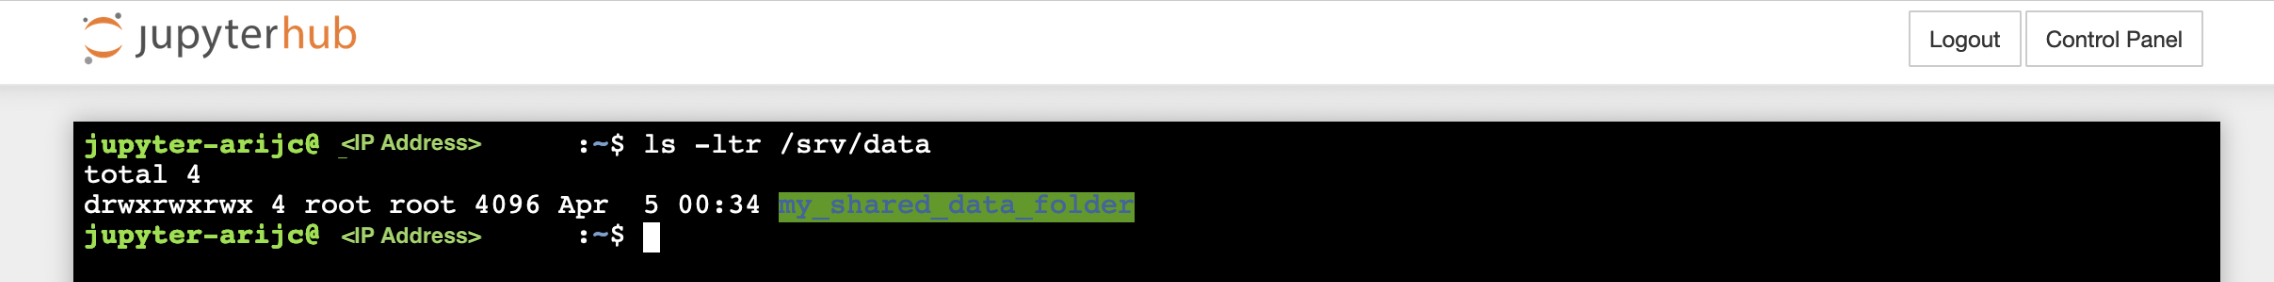

<br>
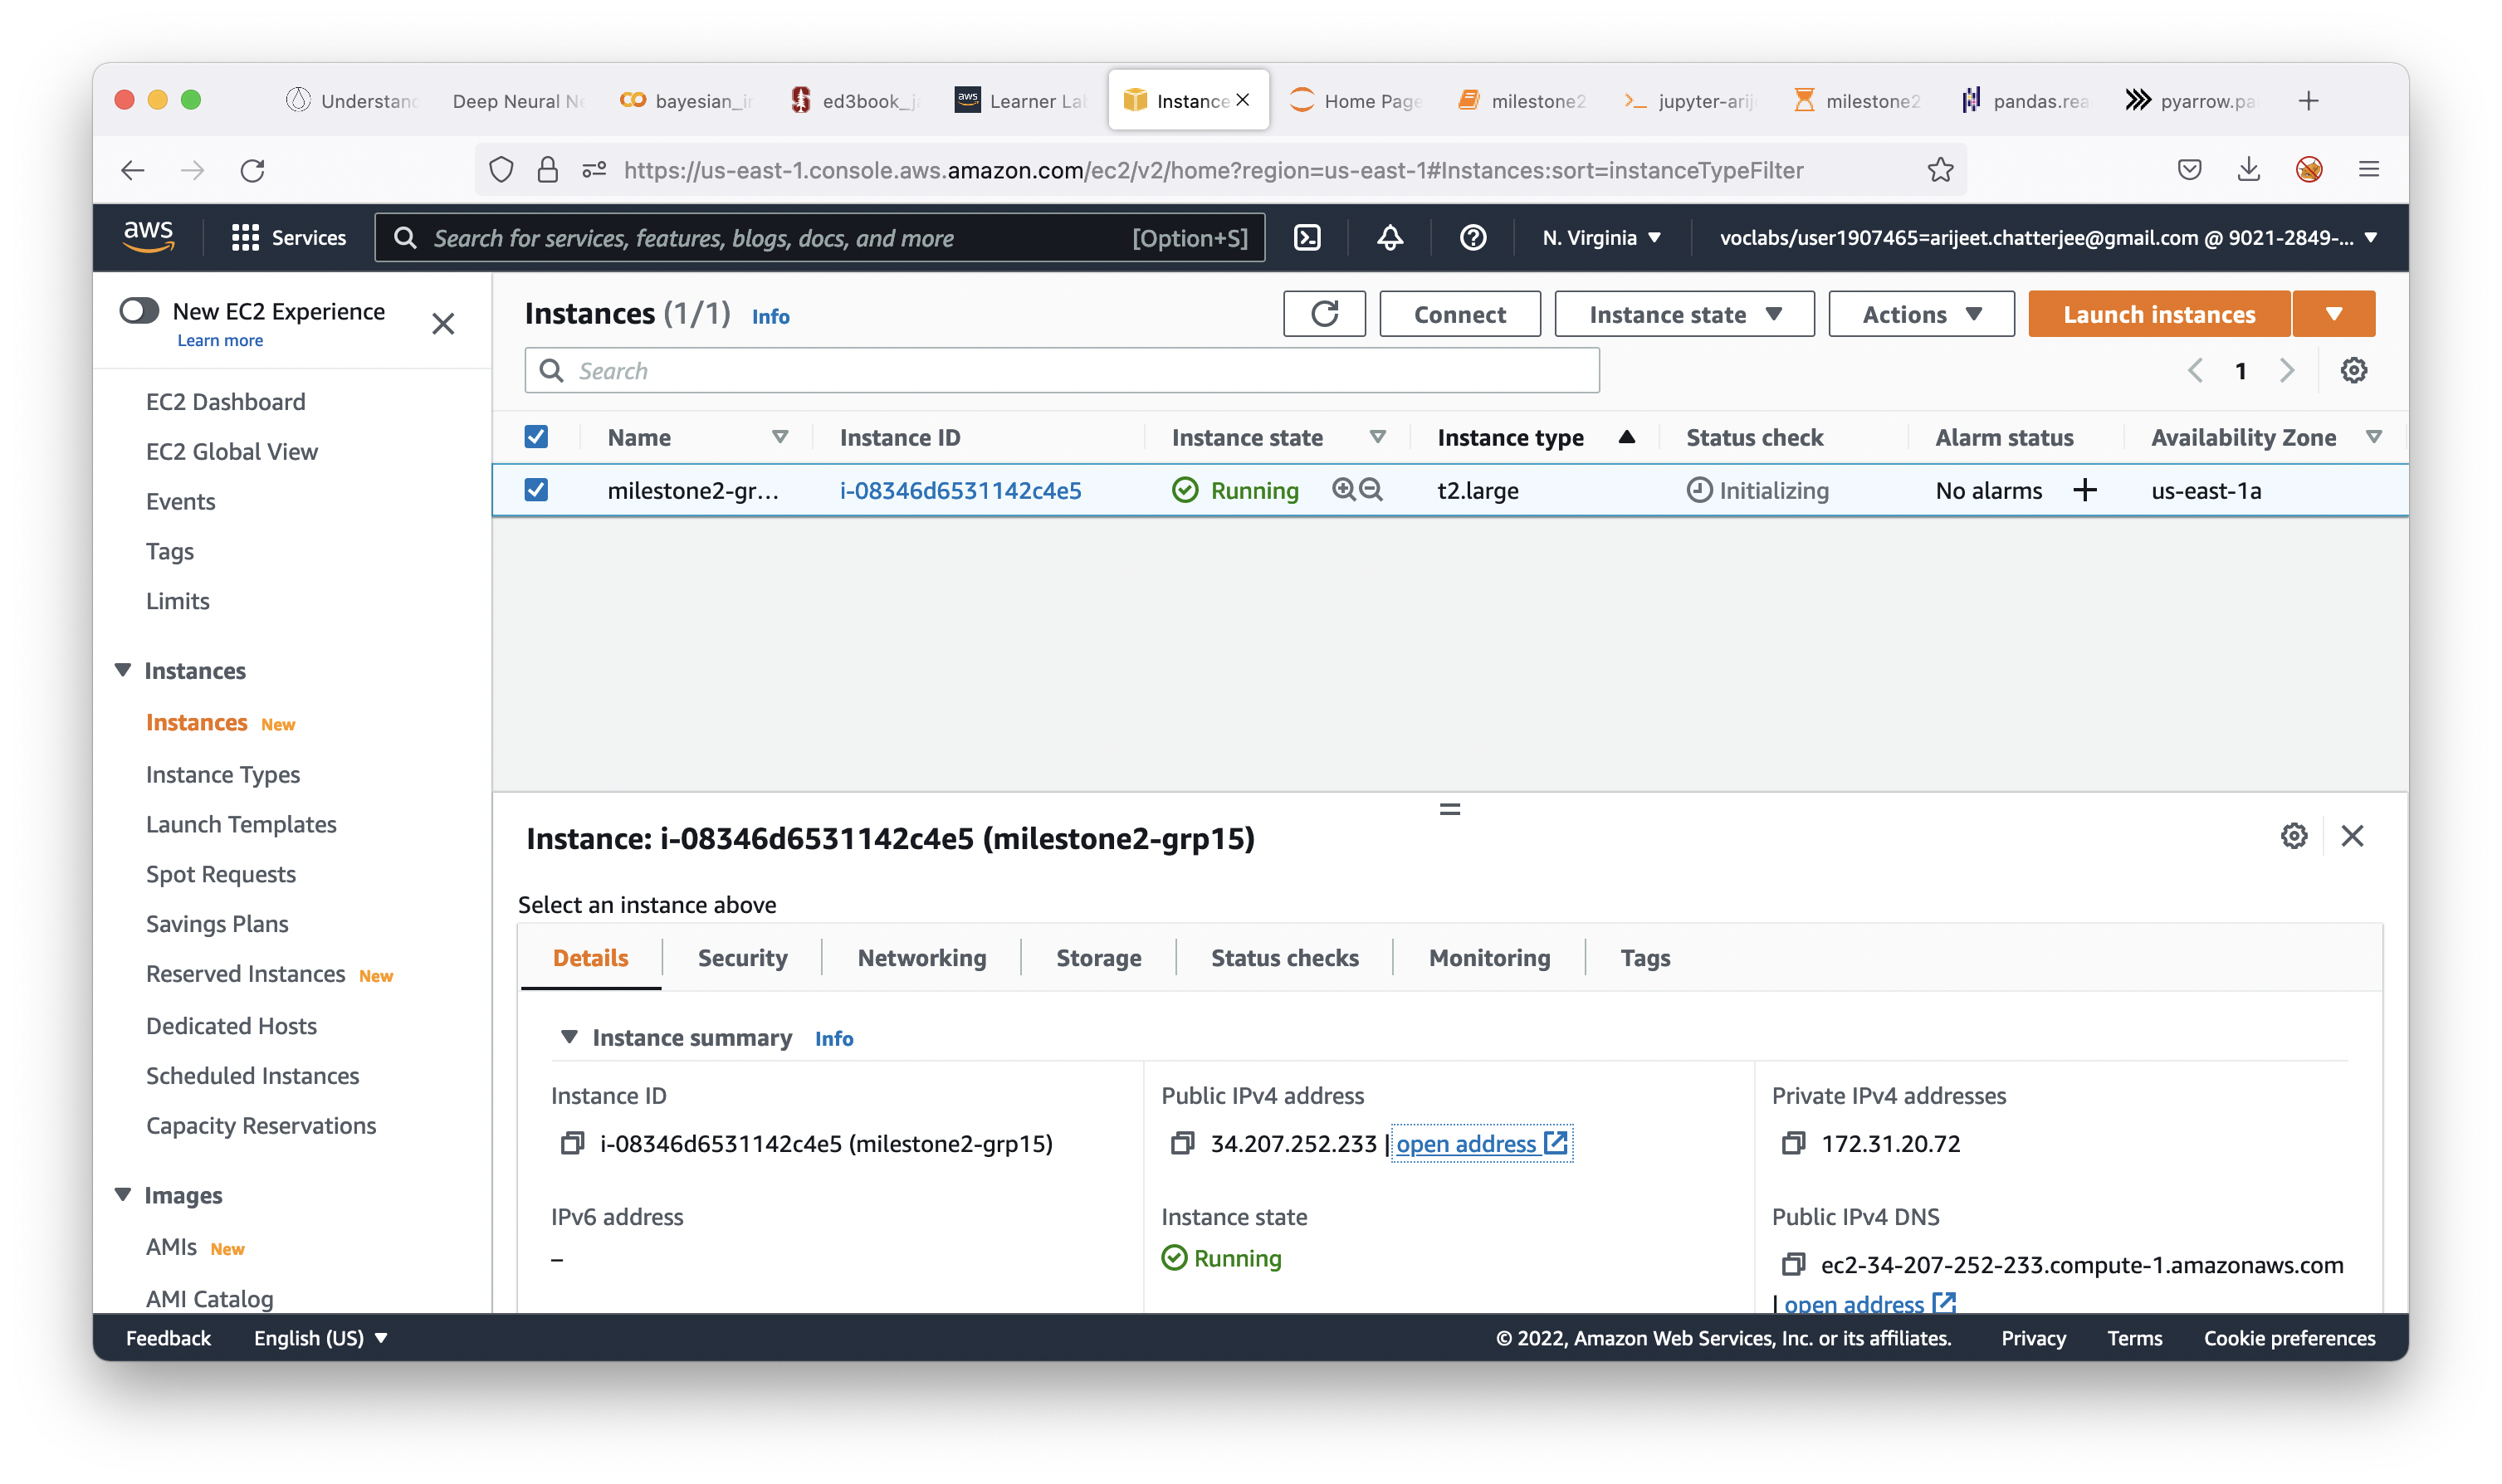

## Imports

In [ ]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd

## 4. Download parquet file

In [31]:
# Necessary metadata
article_id = 14226968  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "/srv/data/my_shared_data_folder/"

In [12]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # this contains all the articles data, feel free to check it out
files = data["files"]             # this is just the data about the files, which is what we want

[{'id': 26844650,
  'name': 'allyears.csv.zip',
  'size': 2405908113,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26844650',
  'supplied_md5': '9e046ac05ecd2c32a256a47dd1098b81',
  'computed_md5': '9e046ac05ecd2c32a256a47dd1098b81'},
 {'id': 26863682,
  'name': 'individual_years.zip',
  'size': 1896206676,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26863682',
  'supplied_md5': '921da748974b07b2a70bbfcc04535a77',
  'computed_md5': '921da748974b07b2a70bbfcc04535a77'},
 {'id': 27515426,
  'name': 'combined_model_data.csv.zip',
  'size': 821308997,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/27515426',
  'supplied_md5': '7638434c44a7d29cbb29fe200b4fd65d',
  'computed_md5': '7638434c44a7d29cbb29fe200b4fd65d'},
 {'id': 27520682,
  'name': 'combined_model_data_parti.parquet.zip',
  'size': 519743915,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/

In [13]:
files_to_dl = ["combined_model_data_parti.parquet.zip"]  ## Please download the partitioned 
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

In [14]:
with zipfile.ZipFile(os.path.join(output_directory, "combined_model_data_parti.parquet.zip"), 'r') as f:
    f.extractall(output_directory)

## 5. Setup S3 bucket and move data

<br>


```
aws s3 cp [source] [target]
```
<br>

Add `--recursive` if folder
Remember to add name of file to `[target]`

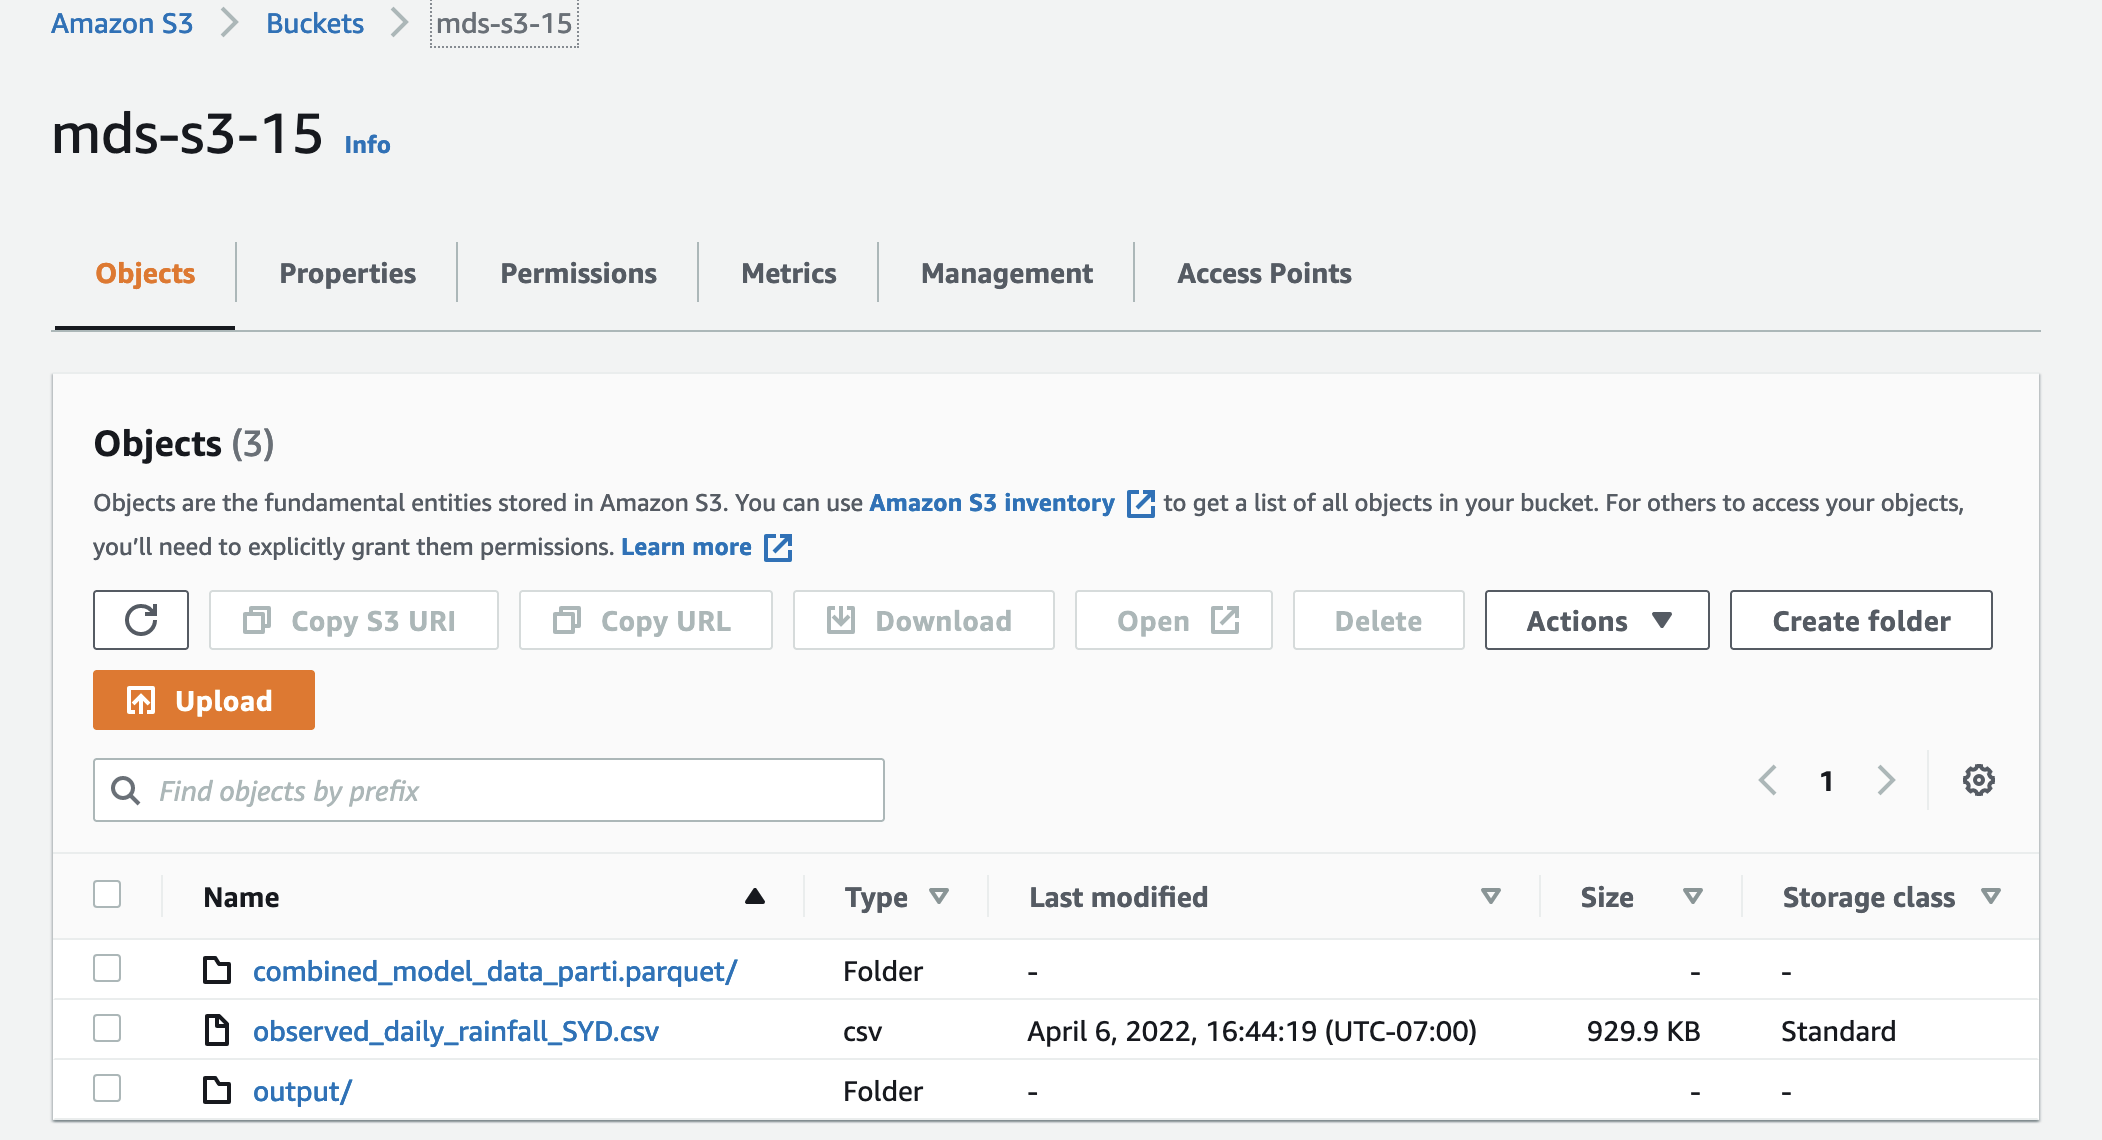
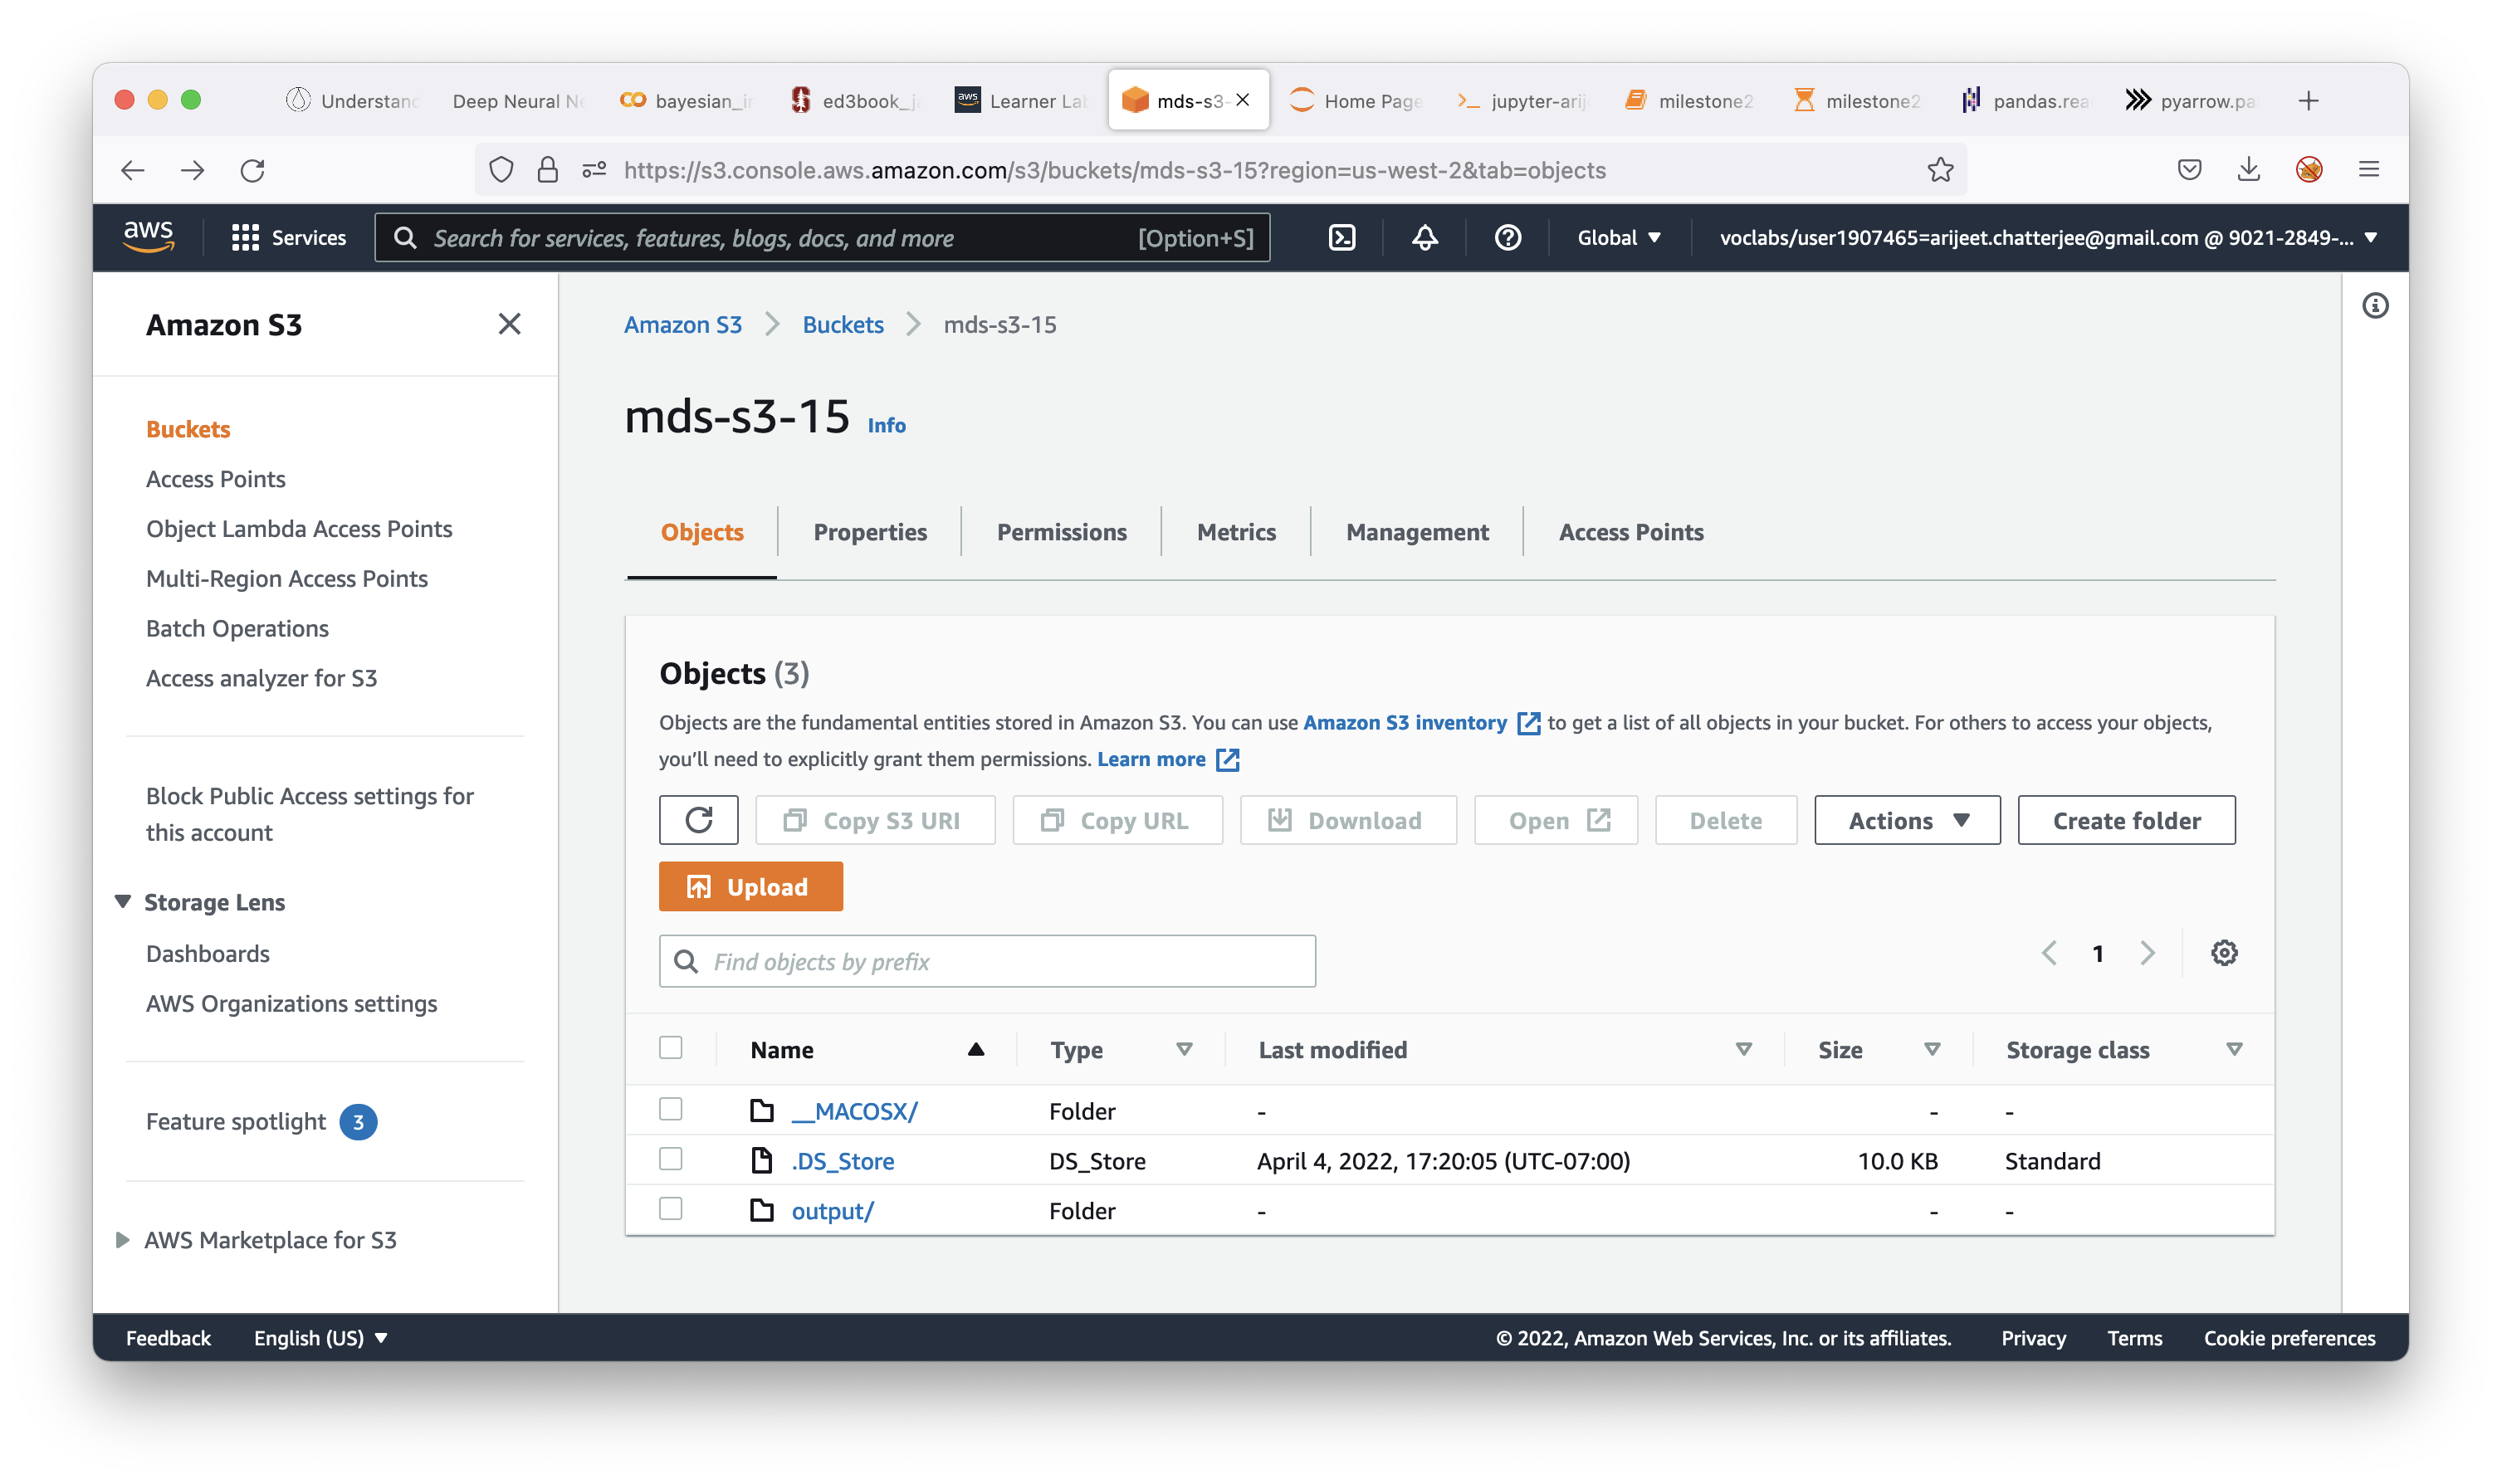

## 6. Data wrangling

In [9]:
df = pd.read_parquet(
    's3://mds-s3-15/output/combined_model_data_parti.parquet', 
    filters=[
        [
            # lat_min < -33.86 < lat_max
            # lon_min < 151.21 < lon_max
            ('lat_min','<=', -33.86),
            ('lat_max','>=', -33.86),
            ('lon_min', '<=', 151.21),
            ('lon_max', '>=', 151.21)
        ]
    ],
    columns=['time', 'rain (mm/day)', 'model']
    
)
df.head()

time  rain (mm/day)       model
0 1889-01-01 12:00:00       0.040427  ACCESS-CM2
1 1889-01-02 12:00:00       0.073777  ACCESS-CM2
2 1889-01-03 12:00:00       0.232656  ACCESS-CM2
3 1889-01-04 12:00:00       0.911319  ACCESS-CM2
4 1889-01-05 12:00:00       0.698013  ACCESS-CM2

In [10]:
df["time"] = df["time"].dt.date
df = df.set_index("time")
df.shape

(1150049, 2)

In [11]:
df = df.pivot(columns="model", values="rain (mm/day)")
df.head()

model       ACCESS-CM2  ACCESS-ESM1-5  AWI-ESM-1-1-LR   BCC-CSM2-MR  \
time                                                                  
1889-01-01    0.040427       1.814552       35.579336  4.268112e+00   
1889-01-02    0.073777       0.303965        4.596520  1.190141e+00   
1889-01-03    0.232656       0.019976        5.927467  1.003845e-09   
1889-01-04    0.911319      13.623777        8.029624  8.225225e-02   
1889-01-05    0.698013       0.021048        2.132686  2.496841e+00   

model           BCC-ESM1  CMCC-CM2-HR4  CMCC-CM2-SR5  CMCC-ESM2   CanESM5  \
time                                                                        
1889-01-01  1.107466e-03     11.410537  3.322009e-08   2.668800  1.321215   
1889-01-02  1.015323e-04      4.014984  1.312700e+00   0.946211  2.788724   
1889-01-03  1.760345e-05      9.660565  9.103720e+00   0.431999  0.003672   
1889-01-04  1.808932e-01      3.951528  1.317160e+01   0.368693  0.013578   
1889-01-05  4.708019e-09      2.766362  1.822940e+01   0.339267  0.002468   

model       EC-Earth3-Veg-LR  ...    MIROC6  MPI-ESM-1-2-HAM  MPI-ESM1-2-HR  \
time                          ...                                             
1889-01-01          1.515293  ...  0.648031     4.244226e-13   1.390174e-13   
1889-01-02          4.771375  ...  1.099883     4.409552e+00   1.222283e-01   
1889-01-03          4.233980  ...  3.931751     2.269300e-01   3.762301e-01   
1889-01-04         15.252495  ...  0.627365     2.344586e-02   4.214019e-01   
1889-01-05         11.920356  ...  0.019777     4.270161e-13   1.879692e-01   

model       MPI-ESM1-2-LR    MRI-ESM2-0         NESM3    NorESM2-LM  \
time                                                                  
1889-01-01   6.537884e-05  3.445495e-06  1.576096e+01  4.759651e-05   
1889-01-02   1.049131e-13  4.791993e-09  3.675510e-01  4.350863e-01   
1889-01-03   9.758706e-14  6.912302e-01  1.562869e-01  9.561101e+00   
1889-01-04   7.060915e-03  3.835721e-02  2.472226e-07  5.301038e-01   
1889-01-05   4.504985e+00  3.506923e-07  1.949792e-13  1.460928e-10   

model       NorESM2-MM  SAM0-UNICON   TaiESM1  
time                                           
1889-01-01    2.451075     0.221324  2.257933  
1889-01-02    0.477231     3.757179  2.287381  
1889-01-03    0.023083     0.253357  1.199909  
1889-01-04    0.002699     2.185454  2.106737  
1889-01-05    0.001026     2.766507  1.763335  

[5 rows x 25 columns]

In [12]:
df.shape

(46020, 25)

In [26]:
obs_df = pd.read_csv(
    's3://mds-s3-15/output/observed_daily_rainfall_SYD.csv',
    parse_dates=["time"]
)
obs_df.head()

time  rain (mm/day)
0 1889-01-01       0.006612
1 1889-01-02       0.090422
2 1889-01-03       1.401452
3 1889-01-04      14.869798
4 1889-01-05       0.467628

In [28]:
obs_df["time"] = obs_df["time"].dt.date
obs_df = obs_df.set_index("time")

df["observed_rainfall"] = obs_df["rain (mm/day)"]
df.head()

model       ACCESS-CM2  ACCESS-ESM1-5  AWI-ESM-1-1-LR   BCC-CSM2-MR  \
time                                                                  
1889-01-01    0.040427       1.814552       35.579336  4.268112e+00   
1889-01-02    0.073777       0.303965        4.596520  1.190141e+00   
1889-01-03    0.232656       0.019976        5.927467  1.003845e-09   
1889-01-04    0.911319      13.623777        8.029624  8.225225e-02   
1889-01-05    0.698013       0.021048        2.132686  2.496841e+00   

model           BCC-ESM1  CMCC-CM2-HR4  CMCC-CM2-SR5  CMCC-ESM2   CanESM5  \
time                                                                        
1889-01-01  1.107466e-03     11.410537  3.322009e-08   2.668800  1.321215   
1889-01-02  1.015323e-04      4.014984  1.312700e+00   0.946211  2.788724   
1889-01-03  1.760345e-05      9.660565  9.103720e+00   0.431999  0.003672   
1889-01-04  1.808932e-01      3.951528  1.317160e+01   0.368693  0.013578   
1889-01-05  4.708019e-09      2.766362  1.822940e+01   0.339267  0.002468   

model       EC-Earth3-Veg-LR  ...  MPI-ESM-1-2-HAM  MPI-ESM1-2-HR  \
time                          ...                                   
1889-01-01          1.515293  ...     4.244226e-13   1.390174e-13   
1889-01-02          4.771375  ...     4.409552e+00   1.222283e-01   
1889-01-03          4.233980  ...     2.269300e-01   3.762301e-01   
1889-01-04         15.252495  ...     2.344586e-02   4.214019e-01   
1889-01-05         11.920356  ...     4.270161e-13   1.879692e-01   

model       MPI-ESM1-2-LR    MRI-ESM2-0         NESM3    NorESM2-LM  \
time                                                                  
1889-01-01   6.537884e-05  3.445495e-06  1.576096e+01  4.759651e-05   
1889-01-02   1.049131e-13  4.791993e-09  3.675510e-01  4.350863e-01   
1889-01-03   9.758706e-14  6.912302e-01  1.562869e-01  9.561101e+00   
1889-01-04   7.060915e-03  3.835721e-02  2.472226e-07  5.301038e-01   
1889-01-05   4.504985e+00  3.506923e-07  1.949792e-13  1.460928e-10   

model       NorESM2-MM  SAM0-UNICON   TaiESM1  observed_rainfall  
time                                                              
1889-01-01    2.451075     0.221324  2.257933           0.006612  
1889-01-02    0.477231     3.757179  2.287381           0.090422  
1889-01-03    0.023083     0.253357  1.199909           1.401452  
1889-01-04    0.002699     2.185454  2.106737          14.869798  
1889-01-05    0.001026     2.766507  1.763335           0.467628  

[5 rows x 26 columns]

In [29]:
df.shape

(46020, 26)

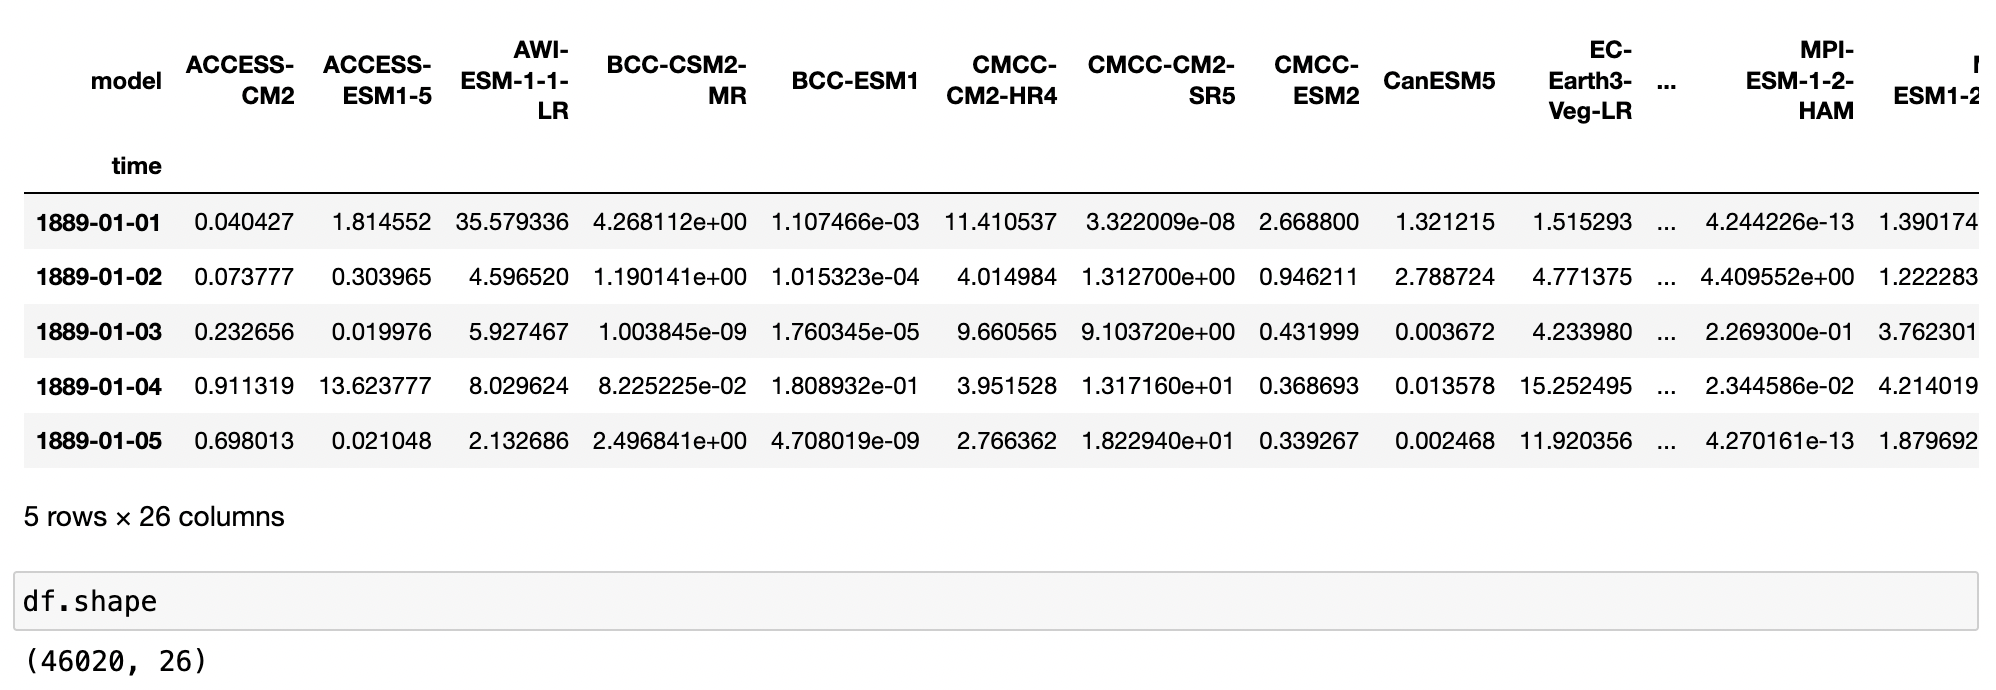

In [32]:
df.to_csv(f"{output_directory}/ml_data_SYD.csv")